# Neural fractional differential equations through deep equilibrium architectures
In this brief tutorial, I will show an idea that I had during my research  ✨, as to implement in practice a differentiable solver for fractional ODEs. Although there are (supposedly) existing [implementations](https://doi.org/10.1088/2632-2153/aba8e7) using the adjoint method, in the code repos they just use [backpropagation](https://github.com/Center-for-Math-AI/Fractional_DNNs) with the numerical solver 🐱. I also was trying to derive and implement the fractional adjoint method and formulas were beyond horrible 💀, so I came up with this alternative.

The core idea is essentially to rewrite the F-ODE system
\begin{equation}
^C_0 D_t^{\alpha} u(t)=\;  I_t^{1-\alpha} \frac{d}{dt} u(t)=f(t,u(t);\theta)
\end{equation}
as an integral equation
\begin{equation}
u(t)=u(0)+\frac{1}{\Gamma(\alpha)}\int_0^t d\tau\;\frac{f(\tau,u(\tau);\theta)}{(t-\tau)^{1-\alpha}}
\end{equation}
using the semigroup property of the fractional integral operator. Now the integro-differential equation became just the fixed point of an integral equation and deep equilibrium models, where the output is implicitely defined by
$$
z^*=f(z^*,x;\theta)
$$
are applicable, where now, notice, we divide $[0,T]$ into $i\Delta t,i=1,\dots,N_t$, then $z^*$ is $\{u(i\Delta t)\}_{i=1}^{N_t}$ living in $\mathbb{R}^{d\times N_t}$ the discretized solution, $x=u(0)\in\mathbb{R}^d$ and $\theta\in\mathbb{R}^p$ are the trainable parameters of the neural network.

In [2]:
# dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import TensorDataset, random_split, DataLoader  
from scipy.special import gamma

In [4]:
class FODE(nn.Module):
    def __init__(self, alpha, T, Nt, d):
        super().__init__()
        self.alpha = alpha
        self.T = T
        self.Nt = Nt
        self.dt = T/Nt
        self.f_theta = nn.Sequential(
            nn.Linear(d,3*d),
            nn.ReLU(),
            nn.Linear(3*d,3*d),
            nn.ReLU(),
            nn.Linear(3*d,d)
        )

    def forward(self, z, x):
        out = torch.zeros_like(z)
        for nt in range(self.Nt):
            t = (nt+1)*self.dt
            out[:,:,nt] = x + self.dt*self.f_theta(x)*t**(self.alpha-1)/gamma(self.alpha)
            for j in range(nt-1):
                out[:,:,nt] += self.dt*self.f_theta(z[:,:,j])*(t-self.dt*(j+1))**(self.alpha-1)/gamma(self.alpha)
        return out


In [5]:
# parameters for FODE
alpha = 0.8
T = 1
Nt = 20
d = 2
n_samples = 3

u0 = torch.randn(n_samples,d)
uT = u0.clone().unsqueeze(-1).expand(-1,-1,Nt)

net = FODE(alpha,T,Nt,d)

Text(0, 0.5, 'Relative residual')

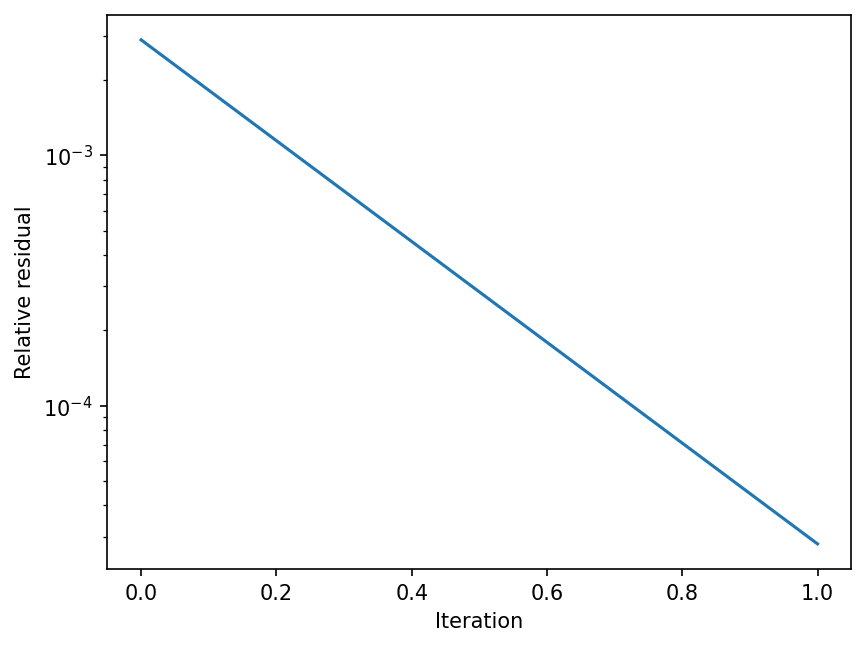

In [6]:
import matplotlib.pyplot as plt
def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

Z, res = forward_iteration(lambda Z : net(Z,u0), uT, tol=1e-4)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")


In [7]:
import torch.autograd as autograd

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x),
                                              torch.zeros_like(x).unsqueeze(-1).repeat(1,1,self.f.Nt),
                                              **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z


Checking that gradients work

In [8]:
from torch.autograd import gradcheck
deq = DEQFixedPoint(net.double(), forward_iteration, tol=1e-10, max_iter=500)
gradcheck(deq, u0.double().requires_grad_(), eps=1e-5, atol=1e-3, check_undefined_grad=False)

True

Now, let's train a realistic example.

In [9]:
def plot3d(uT):
    plt.figure(figsize=(10, 6))

    # Scatter plot for predicted values
    plt.scatter(uT[0, :], uT[1, :], color='blue', alpha=0.6)

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Trayectory')
    plt.legend()
    plt.grid(True)
    plt.show()

In [51]:
n_samples = 1000
d = 3
T = 10
Nt = 12
alpha = 0.8

u0_ex = torch.randn(n_samples, d)
hidden_net = FODE(alpha,T,Nt,d)
hidden_deq = DEQFixedPoint(hidden_net,forward_iteration)
uT_ex = hidden_deq(u0_ex).detach()

/tmp/ipykernel_25522/513374549.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


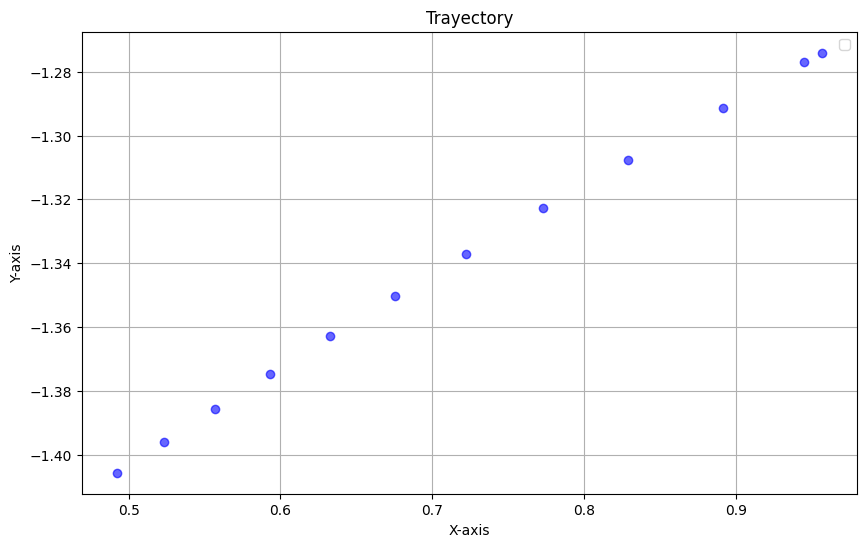

In [52]:
plot3d(uT_ex[4])

In [53]:
dataset = TensorDataset(u0_ex,uT_ex)
trainable_net = FODE(alpha,T,Nt,d)
model = DEQFixedPoint(trainable_net,forward_iteration)

In [54]:
# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size   # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 16  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def epoch(loader, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.MSELoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
                
        total_loss += loss.item() * X.shape[0]

    return total_loss / len(loader.dataset)

# Parameters:  156
0
Epoch 1/50 - Training Loss: 0.3986
Epoch 1/50 - Validation Loss: 0.1675
1
Epoch 2/50 - Training Loss: 0.1294
Epoch 2/50 - Validation Loss: 0.0802
2
Epoch 3/50 - Training Loss: 0.0649
Epoch 3/50 - Validation Loss: 0.0414
3
Epoch 4/50 - Training Loss: 0.0326
Epoch 4/50 - Validation Loss: 0.0232
4
Epoch 5/50 - Training Loss: 0.0190
Epoch 5/50 - Validation Loss: 0.0148
5
Epoch 6/50 - Training Loss: 0.0125
Epoch 6/50 - Validation Loss: 0.0101
6
Epoch 7/50 - Training Loss: 0.0090
Epoch 7/50 - Validation Loss: 0.0074
7
Epoch 8/50 - Training Loss: 0.0069
Epoch 8/50 - Validation Loss: 0.0059
8
Epoch 9/50 - Training Loss: 0.0057
Epoch 9/50 - Validation Loss: 0.0049
9
Epoch 10/50 - Training Loss: 0.0049
Epoch 10/50 - Validation Loss: 0.0042
10
Epoch 11/50 - Training Loss: 0.0044
Epoch 11/50 - Validation Loss: 0.0039
11
Epoch 12/50 - Training Loss: 0.0040
Epoch 12/50 - Validation Loss: 0.0037
12
Epoch 13/50 - Training Loss: 0.0037
Epoch 13/50 - Validation Loss: 0.0035
13
Epoch

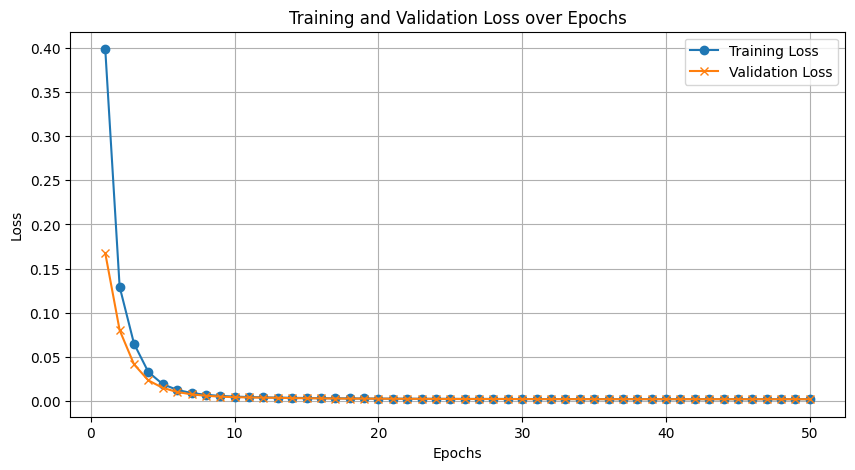

In [56]:
opt = optim.Adam(model.parameters(), lr=1e-3)
max_epochs = 50

scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs * len(train_loader), eta_min=1e-6)

# Print the number of parameters in the model
print("# Parameters: ", sum(p.numel() for p in model.parameters()))

# Hyperparameters
train_losses = []
val_losses = []


# Training and validation loop
for epoch_index in range(max_epochs):
    # Train the model
    train_loss = epoch(train_loader, model, opt, scheduler)
    train_losses.append(train_loss)
    print(f'Epoch {epoch_index+1}/{max_epochs} - Training Loss: {train_loss:.4f}')
    
    # Validate the model
    val_loss = epoch(val_loader, model)
    val_losses.append(val_loss)
    print(f'Epoch {epoch_index+1}/{max_epochs} - Validation Loss: {val_loss:.4f}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, max_epochs + 1), val_losses, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [64]:
def plot2d(u0, uT_pred, uT_true):
    plt.figure(figsize=(10, 6))

    # Scatter plot for initial condition
    plt.scatter(u0[0], u0[1], color='green', s=100, edgecolor='black', label='Initial Condition')

    # Scatter plot for predicted values
    plt.scatter(uT_pred[0, :], uT_pred[1, :], color='blue', alpha=0.6, label='Predicted')

    # Scatter plot for true values
    plt.scatter(uT_true[0, :], uT_true[1, :], color='red', alpha=0.6, label='True')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('2D Trajectory Comparison: Initial Condition, Predicted vs True')
    plt.legend()
    plt.grid(True)
    plt.show()

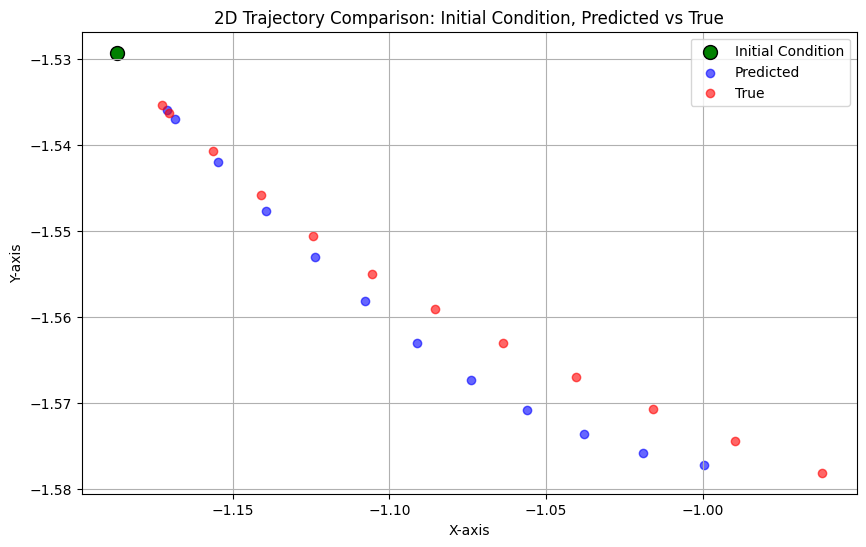

In [67]:
i = 7
pred = model(u0_ex[i]).squeeze(0).detach().numpy()
true = uT_ex[i].numpy()
plot2d(u0_ex[i],pred,true)